<a href="https://colab.research.google.com/github/AndreaPucch/Neural-Networks/blob/main/gMLP_Puccetti_1665823.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pay attention to MLPs
In the paper [Pay Attention to MLPs](https://arxiv.org/pdf/2105.08050v1.pdf), a study on the necessity of self-attention modules in key language and vision applications of transformers is presented. The authors propose an attention-free, MLP-based architecture, which consists of channel projections, spatial projections and gating. The proposed architecture aims to be an alternative to transformers.



# imports

In [ ]:
import os
import time
import copy
import math
import torch
from torch import nn, optim
from torch.distributions.bernoulli import Bernoulli

from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision import models, datasets

from typing import Optional

# Import libraries
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm


# gMLP model 

The model consists of a stack of $L$ blocks with identical structure and size. In each block, $\odot$ refers to element-wise multiplication and all projection operations are linear.

the implementation follows the pseudo-code given in the paper
```python
#      Pseudo-code for the gMLP block
def gmlp_block(x, d_model, d_ffn):
    shortcut = x
    x = norm(x, axis="channel")
    x = proj(x, d_ffn, axis="channel")
    x = gelu(x)
    x = spatial_gating_unit(x)
    x = proj(x, d_model, axis="channel")
    return x + shortcut

def spatial_gating_unit(x):
    u, v = split(x, axis="channel")
    v = norm(v, axis="channel")
    n = get_dim(v, axis="spatial")
    v = proj(v, n, axis="spatial", init_bias=1)
    return u ∗ v
```

Let $X \in R^{n \times d}$ be the token representations with sequence length $n$ and dimension $d$, the chain of operation in each block is defined as follow:
> $ Z = \sigma(XU)$

> $ \bar Z = s(Z)$

> $ Y = \bar Z V$

Where $\sigma$ is defined as GELU activation function, whilst $U$ and $V$ identify linear projections along the channel dimension. $s(\cdot)$ is the Spacial Gating Unit which performs cross-token interactions, described in the next section.

### Stochastic depth
Further in the paper (Chapter 3), the authors declare the implementation of a stochastic depth to avoid a drastical overfit of the training data. Using the stochastic depth approach, each block has a probability of $1-p$ to be bypassed during training. The probability follows the Bernoulli distribution, where samples only assume a binary value, hence either 0 or 1. This stochastic dropout does not affect the evaluation process, where the full model is used for the prediction. More detailed information at [Stochastic depth paper](https://arxiv.org/abs/1603.09382v3).

## Spacial Gating Unit

To enable cross-token interactions, the sgu layer must contain a contraction operation over the spatial dimension. The simplistic option would be a linear projection:

> $ f_{W,b}(Z) = WZ + b $

Where $W \in R^{n \times n}$ is a matrix for which the size is the same as the sequence length $n$, and $b$ refers to a bias term which can either be a matrix or a scalar.

The authors define the spatial interaction unit as the element-wise multiplication of its input and the spatially transformed input:

> $ s(Z) = Z \odot f_{W,b}(Z) $

The previous equation, after splitting the input into 2 independent parts $Z_1$ and $Z_2$, becomes 

> $ s(Z) = Z_1 \odot f_{W,b}(Z_2) $

As last note the authors declare that normalizing the input to $f_{W,b}(Z)$, empirically improves stability. 

***N.B.*** for the initialization of the weight matrix and the bias, this is what the authors say:
> For training stability, we find it critical to initialize $W$ as near-zero values and $b$ as ones, meaning that $s(\cdot)$ is approximately an identity mapping at the beginning of training. This initialization ensures each gMLP block behaves like a regular FFN at the early stage of training, where each token is processed independently, and only gradually injects spatial information across tokens.

## Tiny Attention Layer
The authors experiment with a hybrid model where a tiny self-attention block is attached to the gating function of gMLP. This tiny attention layer has only a single head with size $d_{attn}=64$. In the paper, this hybrid model is referred with the name aMLP, where "a" stands for attention. Its  implementation follows the pseudo-code given in the paper

```python
#      Pseudo-code for the Tiny Attention Layer
def tiny_attn(x, d_ffn, d_attn=64):
    qkv = proj(x, 3 ∗ d_attn, axis="channel")
    q, k, v = split(qkv, 3, axis="channel")
    w = einsum("bnd,bmd−>bnm", q, k)
    a = softmax(w ∗ rsqrt(d_attn))
    x = einsum("bnm,bmd−>bnd", a, v)
return proj(x, d_ffn, axis="channel")
```

In this attention layer the authors designed, query, key and value are obtained through a single linear projection act to triple the size of the input followed by a split.

> **N.B.** here the authors indicate the dimension of the output as equal as the dimension of the hidden dimension of the gMLP block, but the output of the attention layer is summed and then multiply to the 2 output tensors of the SGU, which have dimension $d_{ffn} / 2$. Therefore I made this adjustment in the implementation.

# Implementation
Here the above defined models and layers are implemented

## SGU Implementation
The implementation of the sgu is not particularly complex. The parameters needed to build this block are the dimension of the input $Z$, identified by $d_Z$, and the sequence length $n$. With this information we build the wieght matrix $W$ with near-zero values and the bias array $b$ as array of ones.

In [ ]:
class SGU(nn.Module):
    def __init__(self, d_Z, n):
        super().__init__()

        # normalization layer to improve stability
        self.norm = nn.LayerNorm([d_Z // 2])

        # weight matrix with near-zero values
        self.W = nn.Parameter(torch.zeros(n, n).uniform_(-0.01, 0.01), requires_grad=True)
        self.b = nn.Parameter(torch.ones(n), requires_grad=True)


    def forward(self, z):
        # get weights and bias in the shape of the input
        n = z.shape[0]
        weight = self.W[:n, :n]
        bias = self.b[:n, None, None]

        # split the input in two
        z1, z2 = torch.chunk(z, 2, dim=-1)

        # normalize the input to F_wb(Z)
        z2 = self.norm(z2)

        # apply F_wb(Z) using einsum to perform the "matrix - batch-matrix" multiplication
        # thanks to 
        # https://www.youtube.com/watch?v=pkVwUVEHmfI
        # https://rockt.github.io/2018/04/30/einsum 
        # https://stackoverflow.com/questions/73119792/how-to-multiply-three-arrays-with-different-dimension-in-pytorch
        # for a clear explanation of this very useful function
        z2 = torch.einsum('ij,jkb->ikb', weight, z2) + bias

        #return z1 and z2 separated to facilitate the implementation of the 
        #tiny attention layer
        return z1, z2

## Tiny Attention Layer Implementation
This layer is defined by the authors as a single-head attention with size 64. The implementation follows the pseudo-code showed in the previous section **Tiny Attention Layer**. The input is taken right after the first layer normalization of the gMLP block. The output will be summed with the processed output of the SGU, and finally multiplied by the shortcut of the SGU.

In [ ]:
class TinyAttention(nn.Module):
    def __init__(self, d_ffn, d_attn=64):
        super().__init__()

        self.d_attn = d_attn
        
        #first linear projection
        self.proj1 = nn.Linear(d_model, d_attn *3)

        #second linear projection
        self.proj2 = nn.Linear(d_attn, d_ffn // 2 )


    def forward(self, x):
        #apply first linear projection
        x = self.proj1(x)

        # split the input in query, key and value
        q, k, v = torch.chunk(x, 3, dim=-1)

        #compute the score w
        w = torch.einsum('bij, bkj -> bij', q, k)

        #multiply the score by  the square root of dimension of key 
        #and then apply Softmax
        prod = w / self.d_attn
        a = torch.nn.functional.softmax(prod, dim=-1)

        #multiply by value tensor
        x = torch.einsum('bij, bkj -> bij', a, v)

        #apply last projection
        x = self.proj2(x)

        return x

## gMLP block implementation
The implementation of the single gMLP block, follows the pseudo code presented in the section **gMLP model**. The parameters needed to build this block are the dimension of the dimension of the model $d_{model}$, the dimension of the hidden layer $d_{ffn}$ and the length of the encoded sequence in input $l_{seq}$. With this info we build the gMLP as deisgned in the pseudo code, including the SGU layer above implemented.

In [ ]:
class gMLP_block(nn.Module):
    def __init__(self, d_model, d_ffn, seq_len):
        super().__init__()
        #store size of the model
        self.size = d_model

        # Layer normalization
        self.norm = nn.LayerNorm(d_model)

        # GELU activation layer
        self.gelu = nn.GELU()

        # First linear channel projection
        self.proj1 = nn.Linear(d_model, d_ffn)

        # SGU layer
        self.sgu = SGU(d_ffn, seq_len)

        # Second linear channel projection
        self.proj2 = nn.Linear(d_ffn // 2, d_model)


    def forward(self, x):
        #create copy of the input
        shortcut = x.clone()

        #apply normalization layer
        z = self.norm(x)

        #apply first channel projection
        z = self.proj1(z)
        
        #apply GELU
        z = self.gelu(z)

        #apply SGU layer
        z1, z2 = self.sgu(z)

        #apply second channel projection
        z = self.proj2(z1*z2)

        return z + shortcut


## aMLP block implementation
The only difference with the gMLP block is in the presence of the tiny attention layer.

In [ ]:
#TODO
class aMLP_block(nn.Module):
    def __init__(self, d_model, d_ffn, seq_len):
        super().__init__()
        #store size of the model
        self.size = d_model

        # Layer normalization
        self.norm = nn.LayerNorm(d_model)

        # Tiny attention layer
        self.tiny_att = TinyAttention(d_ffn) 

        # GELU activation layer
        self.gelu = nn.GELU()

        # First linear channel projection
        self.proj1 = nn.Linear(d_model, d_ffn)

        # SGU layer
        self.sgu = SGU(d_ffn, seq_len)

        # Second linear channel projection
        self.proj2 = nn.Linear(d_ffn // 2, d_model)


    def forward(self, x):
        #create copy of the input
        shortcut = x.clone()

        #apply normalization layer
        z = self.norm(x)

        #send normalized input to the tiny attention module
        a = self.tiny_att(z)

        #apply first channel projection
        z = self.proj1(z)
        
        #apply GELU
        z = self.gelu(z)

        #apply SGU layer
        z1, z2 = self.sgu(z)

        #sum the attention tensor to z1 and then multiply the result by z2
        z = (a + z1) * z2

        #apply second channel projection
        z = self.proj2(z)

        return z + shortcut


## gMLP intermiadiary class
The class gMLP is simply an intermediary class used to wrap $L$ gMLP single blocks and to implement the stochastic depth. This last one is achieved using a Bernoulli distribution from the torch.distribution module. At training time, before applying each gMLP block the Bernoulli variable determines whether or not bypassing the actual block. 

In [ ]:
class gMLP(nn.Module):

    def __init__(self, L, d_model, d_ffn, seq_len, survival_prob, attention):
        super().__init__()

        # Create L gMLP blocks and put them in a list thorugh ModuleList function
        # if attention is set to True, create L aMLP blocks
        if attention:
            blocksList = [aMLP_block(d_model, d_ffn, seq_len) for i in range(L)]
        else:
            blocksList = [gMLP_block(d_model, d_ffn, seq_len) for i in range(L)]

        self.blocks = nn.ModuleList(blocksList)

        # Create a Bernoulli distribution for the stochastic depth
        self.prob = Bernoulli(survival_prob)


    def forward(self, x):
        for block in self.blocks:
            #if in training mode, decide whether to bypass this block
            #according to the value of the Bernoulli variable, obtained through sample()
            if(self.training and self.prob.sample().item() == 0.0):
                continue

            x = block(x)

        return x


## Image patch embedder
the authors declare that the input for gMLP follows the same standards for ViT. Hence The input image is decomposed into 16x16 flatten patches and a special cls token is added in front of them.

> *The input and output protocols follow ViT/B16 where the raw image is converted into 16×16 patches at the stem.*

> *Our model uses exactly the same input and output format as BERT (for NLP) and ViT (for vision). For example, when finetuning on language tasks, we concatenate together multiple segments followed by paddings, and the predictions are deduced from the last-layer representation of a reserved cls
symbol.*

This can be done either using some transformation and a linear projection, or using a convolutional 2D projection and a final transformation. The second one is declared to be more performing in the original paper.

---

Sources:

[Implementing image patches](https://sachinruk.github.io/blog/pytorch/data/2021/07/03/Image-Patches.html)

[Implementing visual transformers](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)


In [ ]:
class ImagePatchEmbed(nn.Module) :

    def __init__(self, image_size, n_channels, patch_size, d_model):
        super().__init__()

        # the image size must be dividable by patch size with no remains
        assert image_size % patch_size == 0

        self.patch_size = patch_size

        # the number of patches with size patch_size contained
        # into an image of size image_size
        self.n_patches = (image_size // patch_size)**2

        self.n_channels = n_channels

        # the amount of pixel of the concatenated patches is equal to
        # the square power of the patch size times the number of channels 
        self.n_pixels = n_channels * patch_size**2

        # fully connect layer to embed the patches from
        # the number of pixels to the dimension of the model
        self.proj = nn.Linear(self.n_pixels, d_model)


    def forward(self, x):
        # with b = batch_size, c = n_channels, s = image_size, p = patch_size
        # initial input shape  [b, c, s, s]
        p = self.patch_size

        # input patch decomposition into 
        # [b, c, s//p, s//p, p, p]
        x = x.unfold(2, p, p).unfold(3, p, p)

        # input rearrange into 
        # [b, s//p, s//p, c, p, p]
        x = x.permute( (0,2,3,1,4,5) )

        # input reshaping into 
        # [b, n_patches, n_pixels]
        x = x.reshape( (-1, self.n_patches, self.n_pixels) )

        # apply patch embedding
        x = self.proj(x)

        return x

In [ ]:
class ImagePatchEmbed_conv(nn.Module) :

    def __init__(self, image_size, n_channels, patch_size, d_model):
        super().__init__()

        # the image size must be dividable by patch size with no remains
        assert image_size % patch_size == 0

        self.patch_size = patch_size
        self.d_model = d_model

        # the number of patches with size patch_size contained
        # into an image of size image_size
        self.n_patches = (image_size // patch_size)**2

        self.n_channels = n_channels

        # the amount of pixel of the concatenated patches is equal to
        # the square power of the patch size times the number of channels 
        self.n_pixels = n_channels * patch_size**2

        # using a conv layer instead of a linear one -> performance gains
        self.proj = nn.Conv2d(n_channels, d_model, kernel_size=patch_size, stride=patch_size)


    def forward(self, x):
        # apply convolutional projection
        x = self.proj(x)

        # with b = batch_size, d = d_model
        # initial x shape  [b, d, h, w] 
        # input rearrange into 
        # [b, h, w, d]
        x = x.permute( (0,2,3,1) )

        # input reshaping into 
        # [b, n_patches, n_pixels]
        x = x.reshape( (-1, self.n_patches, self.d_model) )

        return x

## gMLP model class
This is the final class that wraps all of the previous described ones in order to build the gMLP model, or aMLP in case of the inclusion of the tiny attention layer. Here 3 parameters are added in order to make the model customizable regarding 3 different methodology described above.

1.   **proj**. it defines the type of projection to use in the image patch embedder layer. 'linear' stands for simple linear projection, while 'conv' identifies a 2D convolutional projection
2.   **tk_extr**. It defines what method to use to extract the token for the final classification. with 'first' only the first line is considered. With using 'mean' a reduction by mean value of the columns is performed. 
3.    **attention**. Boolean variable which tells whether or not including the tiny attention layer

The 'first' token extraction method is taken from the implementation of [ViT-B16](https://pytorch.org/vision/main/_modules/torchvision/models/vision_transformer.html#vit_b_16) 

In [ ]:
class gMLPNet(nn.Module) :

    def __init__(self, image_size, n_channels, patch_size, n_classes,
                 L, d_model, d_ffn, survival_prob, 
                 proj='linear', tk_extr='first', attention=False ):
        super().__init__()

        self.token_extraction = tk_extr

        self.seq_len = (image_size // patch_size) ** 2

        if proj=='conv':
            self.patch_embedding = ImagePatchEmbed_conv(image_size, n_channels, patch_size, d_model)
        else:
            self.patch_embedding = ImagePatchEmbed(image_size, n_channels, patch_size, d_model)
        
        # COPIED from vit_b_16 code ----------------------------------
        # Add a class token. 
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.seq_len += 1
        # ------------------------------------------------------------

        # get the gMLP blocks, or aMLP if attention is set to True
        self.gmlp = gMLP(L, d_model, d_ffn, self.seq_len, survival_prob, attention)

        self.out = nn.Linear(d_model, n_classes)

    
    def forward(self, x):
        b = x.shape[0]
        
        x = self.patch_embedding(x)

        # COPIED from vit_b_16 code ----------------------------------
        # Expand the class token to the full batch
        batch_class_token = self.cls_token.expand(b, 1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        # ------------------------------------------------------------

        x = self.gmlp(x)

        # slect the method for the reduction before the final layer
        # if 'mean' it sums over the columns and divide by the sequence length
        # otherwise it extracts the first row (as in ViT forward method)
        if self.token_extraction=='mean':
            x = torch.einsum("bij -> bj", x) / self.seq_len
        else:
            # COPIED from vit_b_16 code ----------------------------------
            # Classifier "token" as used by standard language architectures
            x = x[:, 0]
            # ------------------------------------------------------------

        x = self.out(x)
        return x

# Dataset download and preparation
In the application of image classification, the authors of the paper use the ImageNet dataset. It contains 14,197,122 annotated images, with a size of over 160GB. Nevertheless, due to the enourmous amount of data and the available computational hardware (i.e. Colab standard GPU), it would be unpractical and extremely time consuming to adopt the same dataset.

Therefore, the Tiny ImageNet dataset is used in the implementation of this project. It will be simply retrieved by a wget to download the zip archive from the Stanford database, followed by an unzip operation to extract the archive. The dataset is basically reduced version of ImageNet, containing 100,000 training images across 200 classes, and 10,000 test images. 

Another very important difference of the tiny dataset is the dimension of the images. The original ImageNet dataset contains images with resolution 256x256 pixels, whilst the tiny version contains image with resolution 64x64 pixels. To overcome the different image size problem, a series of transformation is necessary. Specifically, the Compose() function from the transform module of torchvision is used to link a chain of transformation, such as conversion to tensor, resize, and normalization.

### Folder re-organization
To load the dataset, I've decided make use of the ImageFolder() function of the datasets module from torchvision. This image loader function requires the images to be arranged in a specific order, which is:
> root/class/image.png

Hence, every image has to be organized in a subfolder having the name of the class it belongs to. The training folder meets this requirement, while the test folder has to be properly re-arranged and organized in the above described division.

In [ ]:
# Download data from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  
# Unzip raw zip file
!unzip -qq 'tiny-imagenet-200.zip'

--2023-02-14 00:38:07--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  14.1MB/s    in 19s     

2023-02-14 00:38:26 (12.2 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



The val_annotations.txt file in the val folder contains contains a list of six tab-separated columns. They represent, in order: 
1. filename
1. class label
1. coordinates, height and width of the bounding box

To re-organize the validation folder, we only need the first two columns.

In [ ]:
# Main dataset directory and training and validation folder paths
DATASET_DIR = 'tiny-imagenet-200' 
TRAIN_DIR = os.path.join(DATASET_DIR, 'train') 
VAL_DIR = os.path.join(DATASET_DIR, 'val')

# Create new validation folder
VAL_DIR_SORTED = os.path.join(DATASET_DIR, 'val_sorted')
if not os.path.exists(VAL_DIR_SORTED):
    os.makedirs(VAL_DIR_SORTED)

# Open and read val_annotations text file
fd = open(os.path.join(VAL_DIR, 'val_annotations.txt'), 'r')
lines = fd.readlines()

# Create dictionary to store pairs in the form
#       class_ID : ArrayList of images
# Class_ID is found on the second column, while the image name on the first one
class_dict = {}
for line in lines:
    cols = line.split('\t')
    class_id = cols[1]
    img_name = cols[0]

    # if class id not present in dictionary yet
    # add it and assign list with one image name in it,
    # otherwise add image name to the list
    if class_id not in class_dict.keys():
        class_dict[class_id] = [img_name]
    else:
        class_dict[class_id].append(img_name)

# close file descriptor
fd.close()

# Define path where the original images are stored
images_folder = os.path.join(VAL_DIR, 'images')

# Each key in the class dictionary corresponds to a unique class ID
# therefore for each key a subfolder with the key name is created
# and all the images connected to that key are moved into the subfolder
for key in class_dict.keys() :
    class_path = os.path.join(VAL_DIR_SORTED, key)

    #create folder if it does not exist
    if not os.path.exists(class_path):
        os.makedirs(class_path)

    # Move images to class folder
    for img in class_dict[key] :
        img_path = os.path.join(images_folder, img)
        if os.path.exists(img_path):
            os.rename(img_path, os.path.join(class_path, img))

## Transformations

As previously mentioned, the original ImageNet dataset contains images with resolution 256x256 pixels, whilst the tiny version contains image with resolution 64x64 pixels. A series of tranformations reshape the input and make it siutable for our applications. I took from the Pytorch documentation of ResNet-152 the suggested values of mean and std for the normalization.

[Pytorch ResNet-152](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet152.html)

In [ ]:
# Define transformation sequence for image pre-processing
# to transform original images (shape = [3,64,64]) into 
# images with shape [3, 224, 224]
# If not using pre-trained model, normalize with [0.5, 0.5, 0.5]
# If using pre-trained ImageNet, normalize with 
# mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

train_transform = T.Compose([
                T.RandomResizedCrop(224),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
                ])

val_transform = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
                ])

## Dataset Loading
Use ImageFolder function to load training and validation datasets

In [ ]:
# Use ImageFolder to generate training and validation pytorch datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR_SORTED, val_transform)

# Training function
The function train_model() is defined in order to facilitate the model's training. It performs the data loadera creation, folowed by training phase and evaluation phase. The evaluation follows the training after each epoch. Loss and accuracy are computed after each phase and printed on screen. The tqdm process bar is used to give a visual representation of the progression of each phase.

After each evaluation, the model with the best performance is saved into a variable, which will be returned at the end of the training, alongside with history of the training and validation statistics (loss and accuracy).

The scheduler is instanciated inside this routine to perform the warm up process, hence resetting the learning rate to it highest value. Inspiration for the implementation was found [here](https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/5).

In [ ]:
# Defining training function to facilitate training of different models

def train_model(model, device, train_dataset, val_dataset, batch_size, use_cuda,
                num_epochs, criterion, optimizer, scheduler_args=None):
    
    # init statistics to return
    stats = {
        "train" : {
            "loss" : [],
            "acc" : []
        },
        "val" : {
            "loss" : [],
            "acc" : []
        },
    }
    
    # Get train and validation data loader using DataLoader function
    # for train loader the shuffle is set to True
    train_loader = DataLoader(train_dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        pin_memory=use_cuda,
                        num_workers=1
                        )

    val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        pin_memory=use_cuda,
                        num_workers=1
                        )
    
    # check whether to use an optimizer scheduler, and if yes instantiate it
    use_scheduler = scheduler_args != None
    if use_scheduler:
        r_steps = scheduler_args["reset_steps"]
        min_lr = scheduler_args["min_lr"]
        scheduler = scheduler_args["type"](optimizer, r_steps, min_lr)

    # to check how much time the whole process takes
    begin = time.time()

    # create initial copy of the model state and set best accuracy to 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # init step for scheduler reset to perform warm up
    step = 0

    # Each epoch has a training phase followed by a validation phase
    for epoch in range(num_epochs):
        print('-' * 10)
        print(f'Epoch {epoch+1}/{num_epochs}')

        #------------- TRAINING -------------
        # start with the training setting model to training mode
        model.train()

        # init statistics 
        running_loss = 0.0
        running_corrects = 0
        start = time.time()

        # Iterate over training dataloader using tqdm progress bar
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # backward propagation and optimize 
                loss.backward()
                optimizer.step()

            # update statistics considering batch size
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # increase step for the scheduler
            if use_scheduler:
                #reset scheduler if number of steps reached
                if step == r_steps:
                    scheduler = scheduler_args["type"](optimizer, r_steps, min_lr)
                    step = 0
                else:
                    scheduler.step()
                    step +=1

        # compute epoch's training loss and accuracy
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        # keep track of epoch's training loss and accuracy
        stats["train"]["loss"].append(epoch_loss)
        stats["train"]["acc"].append(epoch_acc.item())

        # get training time
        duration = time.time() - start

        # print out statistics
        print(f' Time: {duration // 60:.0f}m {duration % 60:.0f}s Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


        #------------- EVALUATION -------------
        # proceed setting model to evaluation mode
        model.eval()

        # init statistics 
        running_loss = 0.0
        running_corrects = 0
        start = time.time()

        # Iterate over validation dataloader using tqdm progress bar
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # update statistics considering batch size
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # compute epoch's validation loss and accuracy
        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects.double() / len(val_dataset)

        # keep track of epoch's validation loss and accuracy
        stats["val"]["loss"].append(epoch_loss)
        stats["val"]["acc"].append(epoch_acc.item())

        # get training time
        duration = time.time() - start

        # print out statistics
        print(f' Time: {duration // 60:.0f}m {duration % 60:.0f}s Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model if best accuracy is reached
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - begin
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, stats

# gMLP model configurations
In the paper, the authors present 3 configurations of the gMLP model: Ti, S and B. These 3 configurations share the majority of the parameters, and the only difference lays in the size of the model, the size of the hidden layer and the probability value for the stochastic depth.


*   **Ti**. Model size of 128 and hidden layer size 768. The probability of the stochastic depth is 0.99.
*   **S**. Model size of 256 and hidden layer size 1536. The probability of the stochastic depth is 0.95.
*   **Ti**. Model size of 512 and hidden layer size 3072. The probability of the stochastic depth is 0.90.

Hence, moving to the next configuration the model size and the hidden size are doubled every time, while the probability decreases. This last one increases the probability of a gMLP block being bypassed with the incresing of the size of the model.



In [ ]:
image_size = 224
n_channels = 3
patch_size = 14
n_classes = len(class_dict)
d_model = 128
d_ffn = 768
n_blocks = 30
    
# Defines the parameters to build the 3 models described in the paper
# the only paramters that change across the different architectures are
# the size of the model and the size of the hidden layer, which doubles every time,
# and the probability of the stochastic depth
Ti_conf = {
            "image_size": image_size,
            "n_channels": n_channels,
            "patch_size": patch_size,
            "n_classes": n_classes,
            "L" : n_blocks,
            "d_model": d_model,
            "d_ffn": d_ffn,
            "survival_prob" : 0.99
            }

S_conf = {
            "image_size": image_size,
            "n_channels": n_channels,
            "patch_size": patch_size,
            "n_classes": n_classes,
            "L" : n_blocks,
            "d_model": d_model*2,
            "d_ffn": d_ffn*2,
            "survival_prob" : 0.95
            }

B_conf = {
            "image_size": image_size,
            "n_channels": n_channels,
            "patch_size": patch_size,
            "n_classes": n_classes,
            "L" : n_blocks,
            "d_model": d_model*4,
            "d_ffn": d_ffn*4,
            "survival_prob" : 0.9
            }

config = {"Ti" : Ti_conf, "S" : S_conf, "B" : B_conf }


## Model variations
The possibility to have small variations in the model architecture and in some mechanism were introduced in the implementation of this project. more specifically these variations include:

*   **Type of projection in the patch embedder**. 'linear' stands for simple linear projection, while 'conv' identifies a 2D convolutional projection
*   **Methodology for the cls token extraction before the final classification layer**. Selecting 'first' only the first line is considered, while using 'mean' a reduction is performed. such a reduction is defined as a summation over the columns followed by a division with the number of rows, therefore the mean value is extracted.
* **Attention**. Whether to use the normal gMLP model or its variation aMLP with the tiny attention layer  

The 3 configurations of the original model are built, alongside with some of their variation to show any differences between them.

After building these 3 original models, it results that the the first 2 are not coherent with the paper regarding the number of trainable parameters, whilst the last configuration shows the same amount declared by the authors.

The type of projection does not affect the number of parameters, but the presence of the attention layer does.



In [ ]:
# Build the 3 original models
original = {"Ti" : {}, "S" : {}, "B" : {} }

print("Original configuration:")
for k in original.keys():
    model = gMLPNet(**config[k])
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    original[k] = {"model" : model, "params" : total_params}
    print(f'\tgMLP_{k} total parameters: {total_params}')
print('')

# Build the 3 models with convolutional projection
with_conv = {"Ti" : {}, "S" : {}, "B" : {} }

print("With convolutional projection:")
for k in with_conv.keys():
    model = gMLPNet(**config[k])
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    with_conv[k] = {"model" : model, "params" : total_params}
    print(f'\tgMLP_{k} conv projection total parameters: {total_params}')
print('')

# Build the models with attention layer
with_attention = {"Ti" : {}, "S" : {}, "B" : {} }

print("With tiny attention layer:")
for k in with_attention.keys():
    model = gMLPNet(**config[k], attention=True)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    with_attention[k] = {"model" : model, "params" : total_params}
    print(f'\taMLP_{k} total parameters: {total_params}')
print('')


Original configuration:
	gMLP_Ti total parameters: 6571780
	gMLP_S total parameters: 20001540
	gMLP_B total parameters: 73403140

With convolutional projection:
	gMLP_Ti conv projection total parameters: 6571780
	gMLP_S conv projection total parameters: 20001540
	gMLP_B conv projection total parameters: 73403140

With tiny attention layer:
	aMLP_Ti total parameters: 8063620
	aMLP_S total parameters: 22242180
	aMLP_B total parameters: 77141380



### Parameters plotting

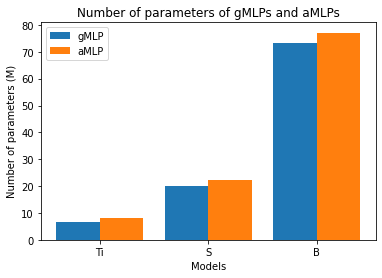

In [ ]:
# Plot the histogram for the parameters of the gMLPs and aMLPs
groups = [k for k in original.keys()]
X_axis = np.arange(len(groups))
g_params=[]
a_params=[]

for k in groups:
    g_params.append(round(original[k]["params"]/1000000, 1) )
    a_params.append(round(with_attention[k]["params"]/1000000, 1) )
  
plt.bar(X_axis - 0.2, g_params, 0.4, label = 'gMLP')
plt.bar(X_axis + 0.2, a_params, 0.4, label = 'aMLP')
  
plt.xticks(X_axis, groups)
plt.xlabel("Models")
plt.ylabel("Number of parameters (M)")
plt.title("Number of parameters of gMLPs and aMLPs")
plt.legend()
plt.show()

# Tests
Here some tests are performed. For simplicity and resource limitations only the **Ti** configuration is considered. 3 different variations will be considered:


1.   Original configuration
2.   Convolutional projection and mean token extraction
3.   Original configuration with attention layer

A very brief training is performed for each of these configurations.



## Training parameters
Here are defined the parameters used for the training process, such as batch size, device used for the computation (GPU if available), loss function, optimizer and optimizer scheduler.

I have tried to remain as close as possible to the ones declared by the authors in the table at page 12, nevertheless some changed were necessary due to the limitations in hardware computing power and resource limit (Colab free GPU runtime). The main differences are:


*   Batch size reduced from 4096 to 128.
*   Cutmix not implemented.
*   Number of epochs reduced from 300 to 10.
*   Cosine scheduler steps set to 100, to adjust to the reduction of the number of epochs.
*   Learning rate of the AdamW optimizer incremented to adapt to the reduced number of epochs.


>**N.B.** Even though a sensitively reduced dataset is used, the Colab resources limitations forbids me to go higher with the epochs. Therefore I do not aim the achieve the same results declared in the paper, but only observing the evolution of the loss and the accuracy

---

[Cosine scheduler restart](https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/5)



In [ ]:
# Define device to use (CPU or GPU) and set model to device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("using device ", device)

# Define the batch size
batch_size = 128

# Define number of epochs
epochs = 10

# Define the cosine scheduler arguments
sched_args = {
              "type" : optim.lr_scheduler.CosineAnnealingLR,    #type of the scheduler
              "reset_steps" : 100,                              #reset scheduler for warmup
              "min_lr" : 3e-4                                   #minimum learning rate
             }

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the training arguments
# model and optimizer must be defined and assigned for each model before training
train_args = {
              "model" : None,
              "device" : device,
              "train_dataset" : train_dataset,
              "val_dataset" : val_dataset,
              "batch_size" : batch_size,
              "use_cuda" : use_cuda,
              "num_epochs" : epochs,
              "criterion" : criterion,
              "optimizer" : None,
              "scheduler_args" : sched_args
             }

using device  cuda


## Training process

### Original configuration

In [ ]:
#instantiate model and set it to device
gMLP_Ti_original = gMLPNet(**config["Ti"])
gMLP_Ti_original.to(device)

# Define the optimizer with increased learning rate
optimizer = optim.AdamW(gMLP_Ti_original.parameters(), lr=3e-2, betas=[0.9,0.999], weight_decay=0.05)

#set the remaining training arguments
train_args["model"] = gMLP_Ti_original
train_args["optimizer"] = optimizer

#start training process
gMLP_Ti_original, stats_original = train_model(**train_args)

----------
Epoch 1/10


100%|██████████| 782/782 [07:59<00:00,  1.63it/s]


 Time: 7m 59s Loss: 22.2589 Acc: 0.0053


100%|██████████| 79/79 [00:28<00:00,  2.76it/s]


 Time: 0m 29s Loss: 6.3970 Acc: 0.0044
----------
Epoch 2/10


100%|██████████| 782/782 [07:53<00:00,  1.65it/s]


 Time: 7m 54s Loss: 6.3343 Acc: 0.0047


100%|██████████| 79/79 [00:29<00:00,  2.70it/s]


 Time: 0m 29s Loss: 5.7032 Acc: 0.0049
----------
Epoch 3/10


100%|██████████| 782/782 [07:52<00:00,  1.65it/s]


 Time: 7m 53s Loss: 5.7503 Acc: 0.0051


100%|██████████| 79/79 [00:28<00:00,  2.80it/s]


 Time: 0m 28s Loss: 5.5440 Acc: 0.0045
----------
Epoch 4/10


100%|██████████| 782/782 [07:53<00:00,  1.65it/s]


 Time: 7m 53s Loss: 5.5361 Acc: 0.0052


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


 Time: 0m 28s Loss: 5.4497 Acc: 0.0045
----------
Epoch 5/10


100%|██████████| 782/782 [07:52<00:00,  1.65it/s]


 Time: 7m 53s Loss: 5.4825 Acc: 0.0049


100%|██████████| 79/79 [00:27<00:00,  2.83it/s]


 Time: 0m 28s Loss: 5.4102 Acc: 0.0048
----------
Epoch 6/10


100%|██████████| 782/782 [07:52<00:00,  1.65it/s]


 Time: 7m 53s Loss: 5.4082 Acc: 0.0048


100%|██████████| 79/79 [00:28<00:00,  2.82it/s]


 Time: 0m 28s Loss: 5.3771 Acc: 0.0059
----------
Epoch 7/10


100%|██████████| 782/782 [07:52<00:00,  1.66it/s]


 Time: 7m 52s Loss: 5.3834 Acc: 0.0053


100%|██████████| 79/79 [00:29<00:00,  2.71it/s]


 Time: 0m 29s Loss: 5.3591 Acc: 0.0046
----------
Epoch 8/10


100%|██████████| 782/782 [07:52<00:00,  1.66it/s]


 Time: 7m 52s Loss: 5.3789 Acc: 0.0047


100%|██████████| 79/79 [00:27<00:00,  2.85it/s]


 Time: 0m 28s Loss: 5.3546 Acc: 0.0051
----------
Epoch 9/10


100%|██████████| 782/782 [07:52<00:00,  1.66it/s]


 Time: 7m 52s Loss: 5.3483 Acc: 0.0053


100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


 Time: 0m 28s Loss: 5.3385 Acc: 0.0056
----------
Epoch 10/10


100%|██████████| 782/782 [07:52<00:00,  1.65it/s]


 Time: 7m 53s Loss: 5.3378 Acc: 0.0052


100%|██████████| 79/79 [00:28<00:00,  2.78it/s]

 Time: 0m 28s Loss: 5.3264 Acc: 0.0049

Training complete in 83m 37s
Best val Acc: 0.005900


### Convolutional projection and mean token extraction

In [ ]:
#instantiate model and set it to device
gMLP_Ti_conv = gMLPNet(**config["Ti"], proj='conv', tk_extr='mean')
gMLP_Ti_conv.to(device)

# Define the optimizer with increased learning rate
optimizer = optim.AdamW(gMLP_Ti_conv.parameters(), lr=3e-2, betas=[0.9,0.999], weight_decay=0.05)

#set the remaining training arguments
train_args["model"] = gMLP_Ti_conv
train_args["optimizer"] = optimizer

#start training process
gMLP_Ti_conv, stats_conv = train_model(**train_args)

----------
Epoch 1/10


100%|██████████| 782/782 [08:24<00:00,  1.55it/s]


 Time: 8m 25s Loss: 14.3514 Acc: 0.0154


100%|██████████| 79/79 [00:28<00:00,  2.79it/s]


 Time: 0m 28s Loss: 5.8118 Acc: 0.0189
----------
Epoch 2/10


100%|██████████| 782/782 [08:28<00:00,  1.54it/s]


 Time: 8m 29s Loss: 5.5410 Acc: 0.0223


100%|██████████| 79/79 [00:28<00:00,  2.74it/s]


 Time: 0m 29s Loss: 5.2858 Acc: 0.0249
----------
Epoch 3/10


100%|██████████| 782/782 [08:20<00:00,  1.56it/s]


 Time: 8m 21s Loss: 5.2204 Acc: 0.0283


100%|██████████| 79/79 [00:28<00:00,  2.75it/s]


 Time: 0m 29s Loss: 5.0632 Acc: 0.0325
----------
Epoch 4/10


100%|██████████| 782/782 [08:21<00:00,  1.56it/s]


 Time: 8m 21s Loss: 5.0428 Acc: 0.0369


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]


 Time: 0m 28s Loss: 4.9083 Acc: 0.0385
----------
Epoch 5/10


100%|██████████| 782/782 [08:20<00:00,  1.56it/s]


 Time: 8m 20s Loss: 4.9117 Acc: 0.0456


100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


 Time: 0m 28s Loss: 4.7695 Acc: 0.0532
----------
Epoch 6/10


100%|██████████| 782/782 [08:20<00:00,  1.56it/s]


 Time: 8m 21s Loss: 4.8046 Acc: 0.0543


100%|██████████| 79/79 [00:28<00:00,  2.82it/s]


 Time: 0m 28s Loss: 4.6710 Acc: 0.0595
----------
Epoch 7/10


100%|██████████| 782/782 [08:20<00:00,  1.56it/s]


 Time: 8m 20s Loss: 4.7290 Acc: 0.0617


100%|██████████| 79/79 [00:27<00:00,  2.83it/s]


 Time: 0m 28s Loss: 4.5774 Acc: 0.0687
----------
Epoch 8/10


100%|██████████| 782/782 [08:20<00:00,  1.56it/s]


 Time: 8m 21s Loss: 4.6526 Acc: 0.0692


100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


 Time: 0m 29s Loss: 4.5189 Acc: 0.0778
----------
Epoch 9/10


100%|██████████| 782/782 [08:21<00:00,  1.56it/s]


 Time: 8m 21s Loss: 4.5762 Acc: 0.0765


100%|██████████| 79/79 [00:28<00:00,  2.77it/s]


 Time: 0m 29s Loss: 4.4291 Acc: 0.0844
----------
Epoch 10/10


100%|██████████| 782/782 [08:21<00:00,  1.56it/s]


 Time: 8m 21s Loss: 4.5030 Acc: 0.0854


100%|██████████| 79/79 [00:28<00:00,  2.81it/s]

 Time: 0m 28s Loss: 4.3742 Acc: 0.0942

Training complete in 88m 23s
Best val Acc: 0.094200


### Original configuration with attention layer

In [ ]:
#instantiate model and set it to device
aMLP_Ti = gMLPNet(**config["Ti"], attention=True)
aMLP_Ti.to(device)

# Define the optimizer with increased learning rate
optimizer = optim.AdamW(aMLP_Ti.parameters(), lr=3e-2, betas=[0.9,0.999], weight_decay=0.05)

#set the remaining training arguments
train_args["model"] = aMLP_Ti
train_args["optimizer"] = optimizer

#batch size has to be reduced due to Colab memory limitation for free accounts
train_args["batch_size"] = 64

#start training process
aMLP_Ti, stats_att = train_model(**train_args)

----------
Epoch 1/10


100%|██████████| 1563/1563 [10:53<00:00,  2.39it/s]


 Time: 10m 53s Loss: 115913.7899 Acc: 0.0055


100%|██████████| 157/157 [00:30<00:00,  5.10it/s]


 Time: 0m 31s Loss: 57574.3969 Acc: 0.0071
----------
Epoch 2/10


100%|██████████| 1563/1563 [10:55<00:00,  2.38it/s]


 Time: 10m 56s Loss: 41410.3477 Acc: 0.0052


100%|██████████| 157/157 [00:30<00:00,  5.13it/s]


 Time: 0m 31s Loss: 28640.7756 Acc: 0.0055
----------
Epoch 3/10


100%|██████████| 1563/1563 [10:55<00:00,  2.39it/s]


 Time: 10m 55s Loss: 22064.1135 Acc: 0.0057


100%|██████████| 157/157 [00:30<00:00,  5.15it/s]


 Time: 0m 31s Loss: 16652.7976 Acc: 0.0062
----------
Epoch 4/10


100%|██████████| 1563/1563 [10:54<00:00,  2.39it/s]


 Time: 10m 54s Loss: 13420.8687 Acc: 0.0054


100%|██████████| 157/157 [00:31<00:00,  5.05it/s]


 Time: 0m 31s Loss: 10621.8923 Acc: 0.0051
----------
Epoch 5/10


100%|██████████| 1563/1563 [10:55<00:00,  2.38it/s]


 Time: 10m 56s Loss: 8586.7772 Acc: 0.0054


100%|██████████| 157/157 [00:31<00:00,  4.98it/s]


 Time: 0m 32s Loss: 6843.5699 Acc: 0.0047
----------
Epoch 6/10


100%|██████████| 1563/1563 [10:54<00:00,  2.39it/s]


 Time: 10m 55s Loss: 5667.1279 Acc: 0.0058


100%|██████████| 157/157 [00:32<00:00,  4.89it/s]


 Time: 0m 32s Loss: 4633.4878 Acc: 0.0085
----------
Epoch 7/10


100%|██████████| 1563/1563 [10:54<00:00,  2.39it/s]


 Time: 10m 55s Loss: 3829.5921 Acc: 0.0064


100%|██████████| 157/157 [00:30<00:00,  5.12it/s]


 Time: 0m 31s Loss: 3171.1091 Acc: 0.0049
----------
Epoch 8/10


100%|██████████| 1563/1563 [10:55<00:00,  2.39it/s]


 Time: 10m 55s Loss: 2583.3027 Acc: 0.0060


100%|██████████| 157/157 [00:30<00:00,  5.13it/s]


 Time: 0m 31s Loss: 2163.2832 Acc: 0.0058
----------
Epoch 9/10


100%|██████████| 1563/1563 [10:54<00:00,  2.39it/s]


 Time: 10m 55s Loss: 1761.8725 Acc: 0.0063


100%|██████████| 157/157 [00:32<00:00,  4.80it/s]


 Time: 0m 33s Loss: 1486.4410 Acc: 0.0055
----------
Epoch 10/10


100%|██████████| 1563/1563 [10:55<00:00,  2.38it/s]


 Time: 10m 55s Loss: 1234.4331 Acc: 0.0065


100%|██████████| 157/157 [00:30<00:00,  5.15it/s]

 Time: 0m 30s Loss: 997.2356 Acc: 0.0048

Training complete in 114m 21s
Best val Acc: 0.008500


## Statistics plotting
Here some statistics are plotted to give a visual representation of the results

### Training time
The average amount of seconds required to perform one epoch, which includes both training and validation phase

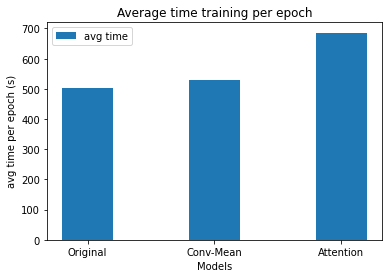

In [ ]:
# Plot the histogram for the parameters of the gMLPs and aMLPs
groups = ["Original", "Conv-Mean", "Attention"]
X_axis = np.arange(len(groups))

#times values are obtained by dividing the time of the training process
#by the number of epochs
times = [502, 530, 686]
  
plt.bar(X_axis, times, 0.4, label = 'avg time')
  
plt.xticks(X_axis, groups)
plt.xlabel("Models")
plt.ylabel("avg time per epoch (s)")
plt.title("Average time training per epoch")
plt.legend()
plt.show()

### Loss and accuracy

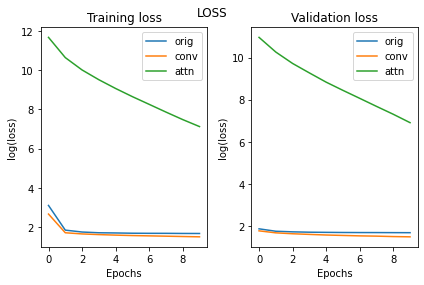

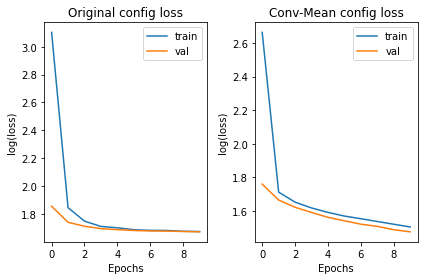

In [ ]:
X_axis = np.arange(epochs)

#plot 1
y1_t = np.array( [math.log(e) for e in stats_original["train"]['loss'] ])
y2_t = np.array( [math.log(e) for e in stats_conv["train"]['loss'] ])
y3_t = np.array( [math.log(e) for e in stats_att["train"]['loss'] ])

plt.subplot(1, 2, 1)
plt.plot(X_axis, y1_t, label='orig')
plt.plot(X_axis, y2_t, label='conv')
plt.plot(X_axis, y3_t, label='attn')
plt.xlabel("Epochs")
plt.ylabel("log(loss)")
plt.title("Training loss")
plt.legend()

#plot 2
y1_v = np.array( [math.log(e) for e in stats_original["val"]['loss'] ])
y2_v = np.array( [math.log(e) for e in stats_conv["val"]['loss'] ])
y3_v = np.array( [math.log(e) for e in stats_att["val"]['loss'] ])

plt.subplot(1, 2, 2)
plt.plot(X_axis, y1_v, label='orig')
plt.plot(X_axis, y2_v, label='conv')
plt.plot(X_axis, y3_v, label='attn')
plt.xlabel("Epochs")
plt.ylabel("log(loss)")
plt.title("Validation loss")
plt.legend()

plt.tight_layout()
plt.suptitle("LOSS")
plt.show()

#-----------------------------------------

#plot 1
plt.subplot(1, 2, 1)
plt.plot(X_axis, y1_t, label='train')
plt.plot(X_axis, y1_v, label='val')
plt.xlabel("Epochs")
plt.ylabel("log(loss)")
plt.title("Original config loss")
plt.legend()

#plot 2
plt.subplot(1, 2, 2)
plt.plot(X_axis, y2_t, label='train')
plt.plot(X_axis, y2_v, label='val')
plt.xlabel("Epochs")
plt.ylabel("log(loss)")
plt.title("Conv-Mean config loss")
plt.legend()

plt.tight_layout()
plt.show()

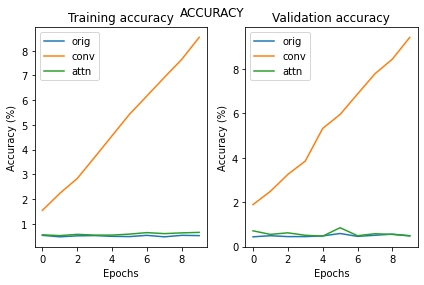

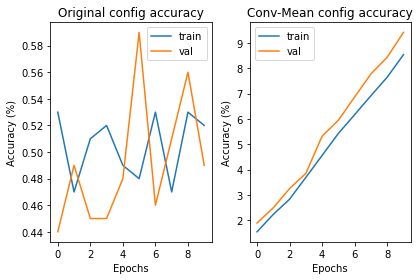

In [ ]:
X_axis = np.arange(epochs)

#plot 1
y1_t = np.array( [round(e*100, 2) for e in stats_original["train"]['acc'] ])
y2_t = np.array( [round(e*100, 2) for e in stats_conv["train"]['acc'] ])
y3_t = np.array( [round(e*100, 2) for e in stats_att["train"]['acc'] ])

plt.subplot(1, 2, 1)
plt.plot(X_axis, y1_t, label='orig')
plt.plot(X_axis, y2_t, label='conv')
plt.plot(X_axis, y3_t, label='attn')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training accuracy")
plt.legend()

#plot 2
y1_v = np.array( [round(e*100, 2) for e in stats_original["val"]['acc'] ])
y2_v = np.array( [round(e*100, 2) for e in stats_conv["val"]['acc'] ])
y3_v = np.array( [round(e*100, 2) for e in stats_att["val"]['acc'] ])

plt.subplot(1, 2, 2)
plt.plot(X_axis, y1_v, label='orig')
plt.plot(X_axis, y2_v, label='conv')
plt.plot(X_axis, y3_v, label='attn')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation accuracy")
plt.legend()

plt.tight_layout()
plt.suptitle("ACCURACY")
plt.show()

#-----------------------------------------

#plot 1
plt.subplot(1, 2, 1)
plt.plot(X_axis, y1_t, label='train')
plt.plot(X_axis, y1_v, label='val')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Original config accuracy")
plt.legend()

#plot 2
plt.subplot(1, 2, 2)
plt.plot(X_axis, y2_t, label='train')
plt.plot(X_axis, y2_v, label='val')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Conv-Mean config accuracy")
plt.legend()

plt.tight_layout()
plt.show()